# IAPWS Implementation

In [2]:
import numpy as np
from numpy import exp
from matplotlib import pylab as plt
%matplotlib inline

*Hack*: Import the neighboring files as a proper module.

In [3]:
import sys, os
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)

In [4]:
from equations_of_state.iapws_boundaries import *
from equations_of_state.iapws97 import *
from equations_of_state.iapws_ice import *

## The phase boundaries

Plot the phase diagram:

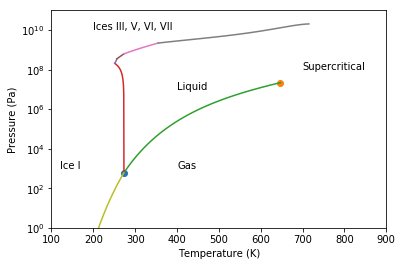

In [5]:
plt.semilogy(triple_point[0],triple_point[1],'o')
plt.semilogy(critical_point[0],critical_point[1],'o')

for f,r in [
    (vapor_pressure,(T_t,T_c)),
    (melting_pressure_I,melting_pressure_range_I),
    (melting_pressure_III,melting_pressure_range_III),
    (melting_pressure_V,melting_pressure_range_V),
    (melting_pressure_VI,melting_pressure_range_VI),
    (melting_pressure_VII,melting_pressure_range_VII),
    (sublimation_pressure,sublimation_pressure_range)
]:
    _ts = np.linspace(r[0],r[1])
    plt.semilogy(_ts,f(_ts),'-')
plt.xlim(100,900)
plt.ylim(1,10.0e10)
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.text(120,1e3,'Ice I')
plt.text(200,1e10,'Ices III, V, VI, VII')
plt.text(400,1e3,'Gas')
plt.text(400,1e7,'Liquid')
plt.text(700,1e8,'Supercritical');
plt.savefig('phase_diagram.png')

# Manipulations

To get the quantities we want, density and enthalpy, we need to perform manipulations on the Gibbs free energy, $g(T,p)$,
\begin{equation}
\rho = \left( \frac{\partial g}{\partial p} \right)^{-1} \\
h = g - T \frac{\partial g}{\partial T}.
\end{equation}
From the Helmholtz free energy, $f(\rho,T)$, the formulae are:
\begin{equation}
p = \rho^2 \frac{\partial f}{\partial \rho} \\
h = f - T \frac{\partial f}{\partial T} + \rho \frac{\partial f}{\partial \rho}
\end{equation}
This is easy to do with a computer, see [algebraic_manipulations.py](algebraic_manipulations.py)

# Testing

The IAPWS provides sets of test values to make sure we typed everything in correctly.

In [6]:
for T,p,h in [(300, 3e6, 0.115331273e6),
              (300, 80e6, 0.184142828e6),
              (500, 3e6, 0.975542239e6)]:
    assert (enthalpy_region1(T,p) - h)/h < 1.0e-8

for T,p,h in [(300, 0.0035e6, 0.254991145e7),
              (700, 0.0035e6, 0.333568375e7),
              (700, 30e6, 0.263149474e7)]:
    assert (enthalpy_region2(T,p) - h)/h < 1.0e8
    
for T,rho,h in [(650, 500, 0.186343019e7),
                (650, 200, 0.237512401e7),
                (750, 500, 0.225868845e7)]:
    assert (enthalpy_region3(T,rho) - h)/h < 1.0e-8
    
assert (enthalpy_ice_I(100,100e6)  + 0.483491635676e6)/1.0e6 < 1.0e-10
assert density_ice_I(100,100e6) - 941.678203297 < 1.0e-10

# The complete EOS surface

In [7]:
resolution = 50
P_span_max = 100.0e6
P_span_min = 100.0
T_span_min = 150.0
T_span_max = 1000.0

## The phase regimes

In [8]:
# Liquid
data_region1 = []
p_melts = np.geomspace(melting_pressure_I(melting_pressure_range_I[1]),
                       P_span_max,
                       resolution)
t_melts = melting_temperature_I(p_melts)
for tm,pm in zip(t_melts,p_melts):
    t_upper = min(623.15,saturation_temperature(pm))
    tslice = np.linspace(tm,t_upper,resolution)
    pslice = pm*np.ones(resolution)
    rho = density_region1(tslice,pm)
    rhoh = rho*enthalpy_region1(tslice,pm)
    data_region1.append( np.vstack([tslice,pslice,rho,rhoh ]).T )
data_region1 = np.vstack(data_region1)

In [9]:
# gas
data_region2 = []
t_subls = np.linspace(200,T_t,resolution)
p_subls = sublimation_pressure(t_subls)
t_vapor = np.linspace(T_t,623.15,resolution)
p_vapor = vapor_pressure(t_vapor)
t_23 = np.linspace(623.15,900,resolution)
p_23 = boundary_region23(t_23)
for tm,pm in zip(np.r_[t_subls,t_vapor,t_23],
                 np.r_[p_subls,p_vapor,p_23]):
    tslice = np.linspace(tm,1000,resolution)
    pslice = pm*np.ones(resolution)
    rho = density_region2(tslice,pm)
    rhoh = rho*enthalpy_region2(tslice,pm)
    data_region2.append( np.vstack([tslice,pslice,rho,rhoh, ]).T )
data_region2 = np.vstack(data_region2)

In [10]:
# supercrit
data_region3 = []
ts = np.linspace(623.15,900,resolution)
rho_upper = density_region1(623.15, P_span_max )
for t in ts:
    tslice = t*np.ones(resolution)
    p_bound = boundary_region23(t)
    rho_bound = density_region2(t,p_bound)
    rhoslice = np.linspace(rho_bound,rho_upper,resolution)
    pslice = pressure_region3(tslice,rhoslice)
    hslice = enthalpy_region3(tslice,rhoslice)
    rhoh = rhoslice * hslice
    data_region3.append( np.vstack([tslice,pslice,rhoslice,rhoh ]).T )
data_region3 = np.vstack(data_region3)

In [11]:
# Ice I
data_ice_I = []
# t_melts = np.linspace(melting_pressure_range_I[0],
#                       melting_pressure_range_I[1],
#                       resolution)
# p_melts = melting_pressure_I(t_melts)
p_melts = np.geomspace(melting_pressure_I(melting_pressure_range_I[0]),
                       melting_pressure_I(melting_pressure_range_I[1]),
                       resolution)
t_melts = melting_temperature_I(p_melts)
t_subls = np.linspace(T_span_min,T_t,resolution)
p_subls = sublimation_pressure(t_subls)
for tm,pm in zip(np.r_[t_melts,t_subls],np.r_[p_melts,p_subls]):
    tslice = np.linspace(T_span_min,tm,resolution)
    pslice = pm*np.ones(resolution)
#     ps = np.linspace(pstart, pend, resolution)
    rho = density_ice_I(tslice,pm)
    rhoh = rho*enthalpy_ice_I(tslice,pm)
    data_ice_I.append( np.vstack([tslice,pslice,rho,rhoh ]).T )
data_ice_I = np.vstack(data_ice_I)

## The equilibria

In [12]:
def equilibria_plane(ts,ps, rho1,h1, rho2,h2):
    data = []
    for tm,pm, rl,hl, rg,hg in zip(ts,ps, rho1,h1, rho2,h2):
        tslice = tm*np.ones(resolution)
        pslice = pm*np.ones(resolution)
        rhoslice = rl + (rg-rl)*np.linspace(0,1,resolution)
        rhslice = rl*hl + (rg*hg-rl*hl)*np.linspace(0,1,resolution)
        data.append( np.vstack([tslice,pslice,rhoslice,rhslice]).T )
    return np.vstack(data)

Here's a huge pitfall: $h$ is per mass, but saturation is per area. The averaging needs to be over mass,
\begin{equation}
h = \frac{\sum_A \rho_A h_A}{\sum_A \rho_A}
\end{equation}
But we instead care about $\rho h$, so I'm just going to train on that.

In [13]:
# Liquid-gas
t_vapor = np.linspace(T_t,T_c,resolution)
p_vapor = vapor_pressure(t_vapor)
rho_liquid = density_region1(t_vapor,p_vapor)
h_liquid   = enthalpy_region1(t_vapor,p_vapor)
rho_gas    = density_region2(t_vapor,p_vapor)
h_gas      = enthalpy_region2(t_vapor,p_vapor)
data_LG_equi = equilibria_plane(t_vapor,p_vapor,rho_liquid,h_liquid,rho_gas,h_gas)

# Solid-gas
rho_liquid = density_ice_I(t_subls,p_subls)
h_liquid   = enthalpy_ice_I(t_subls,p_subls)
rho_gas    = density_region2(t_subls,p_subls)
h_gas      = enthalpy_region2(t_subls,p_subls)
data_SG_equi = equilibria_plane(t_subls,p_subls,rho_liquid,h_liquid,rho_gas,h_gas)

# Solid-liquid
p_melts = np.geomspace(melting_pressure_I(melting_pressure_range_I[1]),
                       P_span_max,
                       resolution)
t_melts = melting_temperature_I(p_melts)
rho_liquid = density_region1(t_melts,p_melts)
h_liquid   = enthalpy_region1(t_melts,p_melts)
rho_gas    = density_ice_I(t_melts,p_melts)
h_gas      = enthalpy_ice_I(t_melts,p_melts)
data_SL_equi = equilibria_plane(t_melts,p_melts,rho_liquid,h_liquid,rho_gas,h_gas)


# 3D Plots

In [15]:
import plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
# plotly.offline.iplot()

T p rho

In [ ]:
macro = lambda D,c, **kwargs : go.Mesh3d(x=D[:,0],y=np.log(D[:,1]),z=D[:,2],color=c,opacity=0.50,**kwargs)
macro = lambda D,c, **kwargs : go.Scatter3d(x=D[:,0],y=np.log(D[:,1]),z=D[:,2],surfacecolor=c,
                                            mode='markers',marker={'size':2},**kwargs)

plot_data = [
    macro(data_ice_I,'red',     name='Ice'),
    macro(data_region1,'blue',  name='Liquid'),
    macro(data_region2,'yellow', name='Gas'),
    macro(data_region3,'green', name='Supercritical'),
    
    macro(data_LG_equi,'gray', name='LG'),
    macro(data_SL_equi,'gray', name='SL'),
    macro(data_SG_equi,'gray', name='SG'),

# go.Scatter3d(x=data_region3[:,0],y=np.log(data_region3[:,1]),z=data_region3[:,2]),
    go.Scatter3d(x=[T_t,T_t],y=np.log([p_t,p_t]),z=[0,1000],mode='lines',line={'width':15},name='Triple pt')
]
layout = go.Layout(scene=dict(
    xaxis=dict(
        title='T',
    ),
    yaxis=dict(
        title='log(p)'
    ),
    zaxis=dict(
        title='rho'
    )
))
fig = go.Figure(data=plot_data,layout=layout)
py.iplot(fig,filename='water_eos_Tprho.html');
# plotly.io.write_image(fig, 'figures/water_eos.png')

T p h

In [ ]:
macro = lambda D,c, **kwargs : go.Mesh3d(x=D[:,0],y=np.log(D[:,1]),z=D[:,2],color=c,opacity=0.50,**kwargs)
macro = lambda D,c, **kwargs : go.Scatter3d(x=D[:,0],y=np.log(D[:,1]),z=D[:,3],surfacecolor=c,
                                            mode='markers',marker={'size':2},**kwargs)

plot_data = [
    macro(data_ice_I,'red',     name='Ice'),
    macro(data_region1,'blue',  name='Liquid'),
    macro(data_region2,'yellow', name='Gas'),
    macro(data_region3,'green', name='Supercritical'),
    
    macro(data_LG_equi,'gray', name='LG'),
    macro(data_SL_equi,'gray', name='SL'),
    macro(data_SG_equi,'gray', name='SG'),

# go.Scatter3d(x=data_region3[:,0],y=np.log(data_region3[:,1]),z=data_region3[:,2]),
    go.Scatter3d(x=[T_t,T_t],y=np.log([p_t,p_t]),z=[0,1000],mode='lines',line={'width':15},name='Triple pt')
]
layout = go.Layout(scene=dict(
    xaxis=dict(
        title='T',
    ),
    yaxis=dict(
        title='log(p)'
    ),
    zaxis=dict(
        title='rho h'
    ),  
),margin=dict(t=0,b=0,l=0,r=0),)
fig = go.Figure(data=plot_data,layout=layout)
py.iplot(fig,filename='water_eos_Tph.html');


# Save the surface to a file

This is the full 3D surface:

In [14]:
stacked_data = np.vstack([
    data_ice_I,
    data_region1,
    data_region2,
    data_region3,
    data_LG_equi,
    data_SL_equi,
    data_SG_equi,
])
np.savetxt('water_iapws.csv',stacked_data,
           delimiter=',',header='T,p,rho,h',comments='')


And we want a second version that takes the Log of the pressure, which spreads it all out better. Note that we used a logarithmic spacing in the points anyways.

In [15]:
stacked_data_logp = stacked_data.copy()
stacked_data_logp[:,1] = np.log(stacked_data[:,1])
np.savetxt('water_iapws_logp.csv',stacked_data_logp,
           delimiter=',',header='T,p,rho,h',comments='')


Let's cut down stacked data to a smaller range around just the Liquid-Gas envelop

In [16]:
stacked_data_LG = np.vstack([
    data_region1,
    data_region2,
    data_region3,
    data_LG_equi,
])
P_max = 1.0e6
P_min = 1000.0
T_max = 600
T_min = 273.15
trimmed = np.array([a for a in stacked_data_LG if a[1]>P_min and a[1]<P_max and a[0]>T_min and a[0]<T_max])
np.savetxt('water_iapws_lg.csv', trimmed,
           delimiter=',',header='T,p,rho,h',comments='')

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=trimmed[:,0],y=trimmed[:,1],z=trimmed[:,3])],layout=layout)
py.iplot(fig);